# Customer Segmentation for E-commerce

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Simulate e-commerce customer data
np.random.seed(42)
n_samples = 1000

# Generate synthetic customer data
data = {
    'age': np.random.randint(18, 70, n_samples),
    'annual_income_k': np.random.normal(45, 15, n_samples).clip(15, 150),
    'spending_score': np.random.normal(50, 20, n_samples).clip(1, 100),
    'avg_order_value': np.random.exponential(75, n_samples).clip(10, 500),
    'purchase_frequency': np.random.poisson(3, n_samples) + 1,
    'time_on_site_min': np.random.normal(12, 4, n_samples).clip(1, 30),
    'product_views': np.random.poisson(15, n_samples),
    'cart_abandonment_rate': np.random.beta(2, 5, n_samples),
    'customer_tenure_months': np.random.exponential(12, n_samples).clip(1, 36),
    'returns_rate': np.random.beta(1, 20, n_samples)
}

df = pd.DataFrame(data)

# 2. Data Cleaning & Preprocessing

In [2]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check for outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print(f"\nOutliers detected: {outliers.sum()}")

# Handle outliers - cap extreme values
for col in df.columns:
    q95 = df[col].quantile(0.95)
    q05 = df[col].quantile(0.05)
    df[col] = np.where(df[col] > q95, q95, df[col])
    df[col] = np.where(df[col] < q05, q05, df[col])

# Standardize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_features, columns=df.columns)

Missing values per column:
age                       0
annual_income_k           0
spending_score            0
avg_order_value           0
purchase_frequency        0
time_on_site_min          0
product_views             0
cart_abandonment_rate     0
customer_tenure_months    0
returns_rate              0
dtype: int64

Outliers detected: 157


# 3. Exploratory Data Analysis

               age  annual_income_k  spending_score  avg_order_value  \
count  1000.000000      1000.000000     1000.000000      1000.000000   
mean     43.824000        45.867135       50.425603        68.703248   
std      14.773194        13.606992       17.846643        57.957416   
min      20.000000        21.661051       18.102517        10.000000   
25%      31.000000        35.822467       37.170342        20.219221   
50%      44.000000        45.807531       50.076277        50.016853   
75%      56.000000        55.282053       63.685132       100.947778   
max      67.000000        70.540344       82.313286       206.595467   

       purchase_frequency  time_on_site_min  product_views  \
count         1000.000000       1000.000000    1000.000000   
mean             3.968000         11.873368      15.173000   
std              1.459145          3.851239       3.603895   
min              2.000000          4.916635       9.000000   
25%              3.000000          8.9606

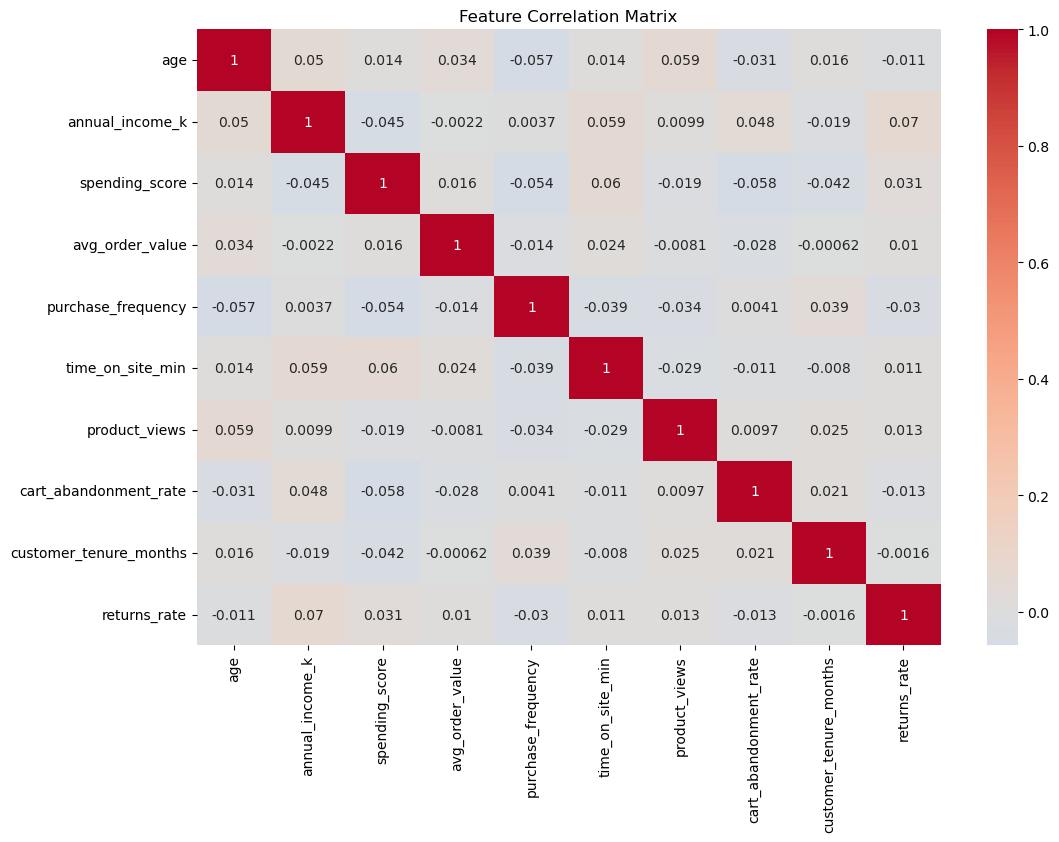

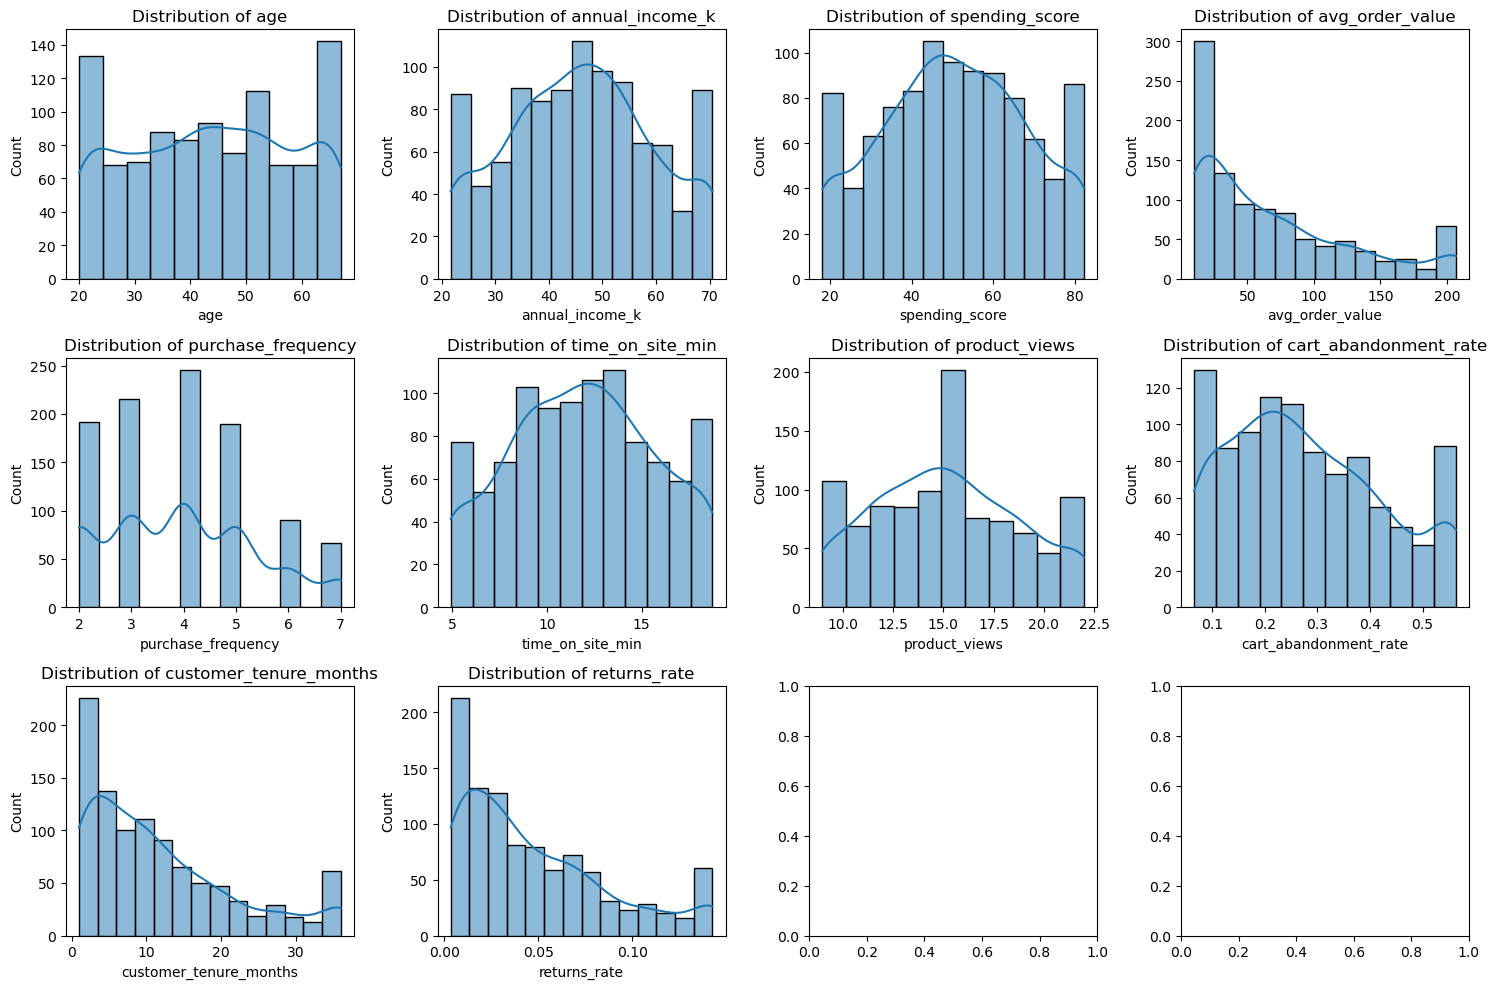

In [3]:
# Statistical summary
print(df.describe())

# Correlation analysis
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# Distribution visualization
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for idx, col in enumerate(df.columns):
    ax = axes[idx//4, idx%4]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 4. Dimensionality Reduction

## Principal Component Analysis (PCA)

Original dimensions: 10
Reduced dimensions: 10
Variance explained: 100.00%


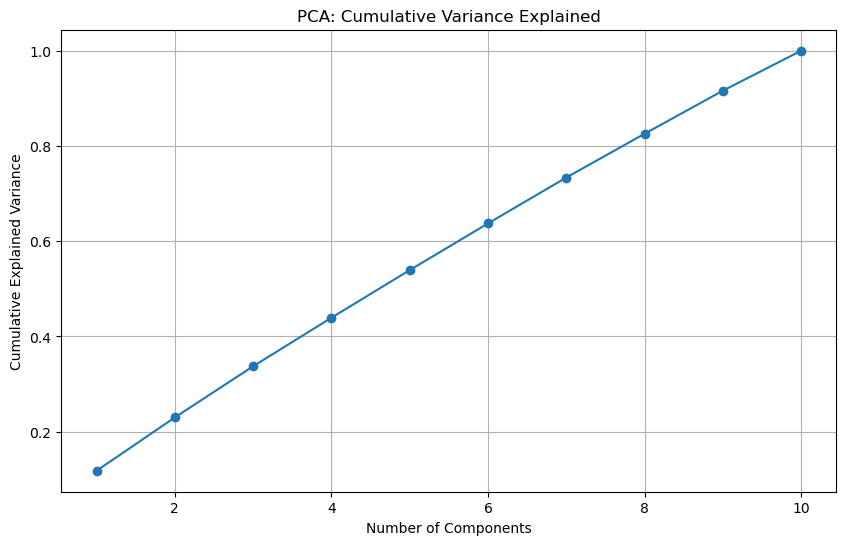

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
pca_result = pca.fit_transform(df_scaled)

print(f"Original dimensions: {df_scaled.shape[1]}")
print(f"Reduced dimensions: {pca_result.shape[1]}")
print(f"Variance explained: {sum(pca.explained_variance_ratio_):.2%}")

# Visualize explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Variance Explained')
plt.grid(True)
plt.show()

# 5. Classification/Clustering Algorithm Selection

Chosen Algorithm: Gaussian Mixture Models (GMM)
Justification:
Dataset Characteristics:
Mixed Distributions: Customer behavior metrics often follow Gaussian-like distributions but with different scales and variances

Soft Clustering: Customers may belong to multiple segments with varying probabilities

Irregular Cluster Shapes: Behavioral clusters are rarely perfectly spherical

10 Features → Reduced to 4-5 principal components



Algorithm Advantages:
Probabilistic Assignment:

python
# GMM provides probability scores for each cluster
# Example: Customer might be 60% "Value Shopper", 30% "Impulse Buyer"
Flexibility in Cluster Shapes:

Unlike K-Means (assumes spherical clusters)

Can model elliptical clusters through covariance matrices

Handles Overlapping Clusters:

Realistic for customer segmentation

Customers often exhibit mixed behaviors

Information Criterion for Model Selection:

BIC/AIC helps determine optimal cluster count

No need for heuristic methods like elbow curve

Comparison with Alternatives:
Algorithm	Pros	Cons for Our Case
K-Means	Fast, simple	Assumes spherical clusters, hard assignments
DBSCAN	Finds arbitrary shapes	Struggles with varying density clusters
Hierarchical	Visual dendrogram	Computationally heavy for 1000 samples
GMM	Soft clustering, flexible shapes	Slightly slower but appropriate

Business Context Alignment:
Marketing: Probabilistic memberships enable targeted campaigns

Resource Allocation: Understand segment proportions precisely

Customer Journey: Model transitions between segments over time

## 6. Implementation Plan

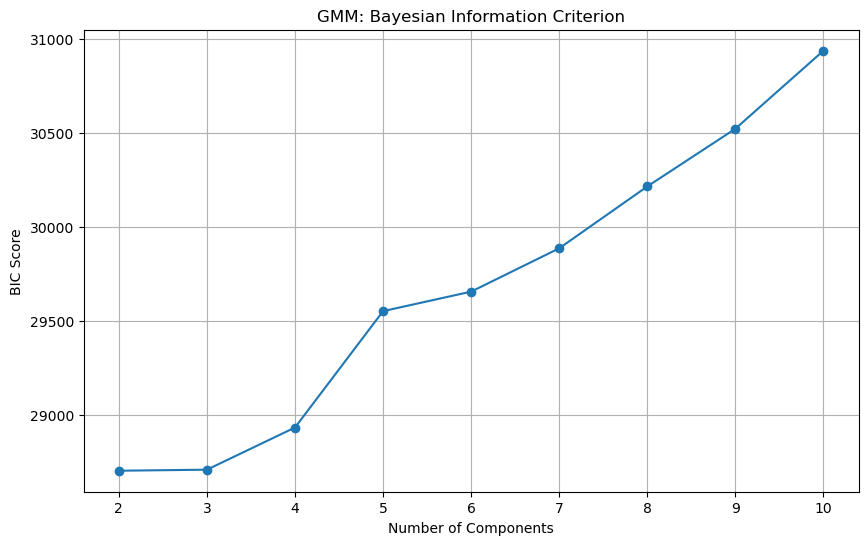


Cluster proportions:
0    0.228
1    0.217
2    0.129
3    0.225
4    0.201
Name: proportion, dtype: float64


In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Determine optimal clusters using BIC
bic_scores = []
n_components_range = range(2, 11)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, 
                         covariance_type='full',
                         random_state=42)
    gmm.fit(pca_result)
    bic_scores.append(gmm.bic(pca_result))

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('GMM: Bayesian Information Criterion')
plt.grid(True)
plt.show()

# Final model with optimal clusters (example: 5 clusters)
optimal_clusters = 5
gmm_final = GaussianMixture(n_components=optimal_clusters, 
                           covariance_type='full',
                           random_state=42)
cluster_labels = gmm_final.fit_predict(pca_result)
probabilities = gmm_final.predict_proba(pca_result)

# Analysis of results
print(f"\nCluster proportions:")
print(pd.Series(cluster_labels).value_counts(normalize=True).sort_index())

# 7. Expected Outcomes & Business Applications

Segmentation Results:

High-value frequent shoppers

Bargain hunters

Occasional luxury buyers

New customer cohort

At-risk customers

Actionable Insights:

Personalized marketing strategies

Customer retention programs

Inventory planning based on segment preferences

Pricing strategy optimization

Model Evaluation:

Silhouette score for cohesion/separation

Calinski-Harabasz index

Business validation through campaign performance

This approach balances statistical rigor with practical business applicability, providing both hard segments for targeted actions and probabilistic insights for nuanced customer understanding.